# 載入所需套件

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp2d
from datetime import datetime
from tqdm import tqdm

%matplotlib inline

#設定字體和解決圖像中文顯示問題
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False

# 建構選擇權報價矩陣表格

In [2]:
dates=[datetime(2015,3,25),datetime(2015,4,25),datetime(2015,6,25),datetime(2015,9,25)]
strikes=[2.2,2.3,2.4,2.5,2.6]
black_vol_matrix=np.array([[0.32562851,0.29746885,0.29260648,0.27679993],
                           [0.28841840,0.29196629,0.27385023,0.26511898],
                           [0.27659511,0.27350773,0.25887604,0.25283775],
                           [0.26969754,0.25565971,0.25803327,0.25407669],
                           [0.27773032,0.24823248,0.27340796,0.24814975]])
table=pd.DataFrame(black_vol_matrix*100,index=strikes,columns=dates)
table.index.name='履約價'
table.columns.name='到期時間'

table

到期時間,2015-03-25 00:00:00,2015-04-25 00:00:00,2015-06-25 00:00:00,2015-09-25 00:00:00
履約價,,,,
2.2,32.562851,29.746885,29.260648,27.679993
2.3,28.841840,29.196629,27.385023,26.511898
2.4,27.659511,27.350773,25.887604,25.283775
2.5,26.969754,25.565971,25.803327,25.407669
2.6,27.773032,24.823248,27.340796,24.814975


# 計算選擇權報價變異數矩陣

In [3]:
eval_date=datetime(2015,3,3)
delta_T=np.array([(d-eval_date).days/365.0 for d in dates])
var_matrix=(black_vol_matrix**2)*delta_T
var_matrix

array([[0.00639109, 0.0128489 , 0.02674114, 0.04324205],
       [0.0050139 , 0.01237794, 0.02342277, 0.03966943],
       [0.00461125, 0.01086231, 0.02093128, 0.03607931],
       [0.00438413, 0.0094909 , 0.02079521, 0.03643376],
       [0.00464918, 0.00894747, 0.02334717, 0.03475378]])

# 選擇權報價變異數線性插值

In [4]:
inter_func=interp2d(delta_T,strikes,var_matrix,kind='linear')
K_Meshes=np.linspace(strikes[0],strikes[-1],400)
T_Meshes=np.linspace(delta_T[0],delta_T[-1],200)
inter_var_surface=np.zeros((len(K_Meshes),len(T_Meshes)))

for i,K in enumerate(K_Meshes):
    for j,T in enumerate(T_Meshes):
        inter_var_surface[i][j]=inter_func(T,K)

inter_vol_surface=np.sqrt(inter_var_surface/T_Meshes)

print('履約價方向網格數 ： {}'.format(np.size(inter_vol_surface,0)))
print('到期時間方向網格數 ： {}'.format(np.size(inter_vol_surface,1)))

inter_vol_surface

履約價方向網格數 ： 400
到期時間方向網格數 ： 200


array([[0.32562851, 0.32376534, 0.32203709, ..., 0.27698235, 0.27689075,
        0.27679993],
       [0.3252766 , 0.32343236, 0.32172174, ..., 0.2768669 , 0.27677569,
        0.27668527],
       [0.32492431, 0.32309903, 0.32140609, ..., 0.2767514 , 0.27666059,
        0.27657057],
       ...,
       [0.27757155, 0.27565807, 0.2738811 , ..., 0.24856254, 0.24841564,
        0.24826998],
       [0.27765094, 0.27572781, 0.27394183, ..., 0.24850503, 0.24835683,
        0.24820987],
       [0.27773032, 0.27579754, 0.27400254, ..., 0.24844751, 0.248298  ,
        0.24814975]])

# 繪製選擇權波動度微笑曲線

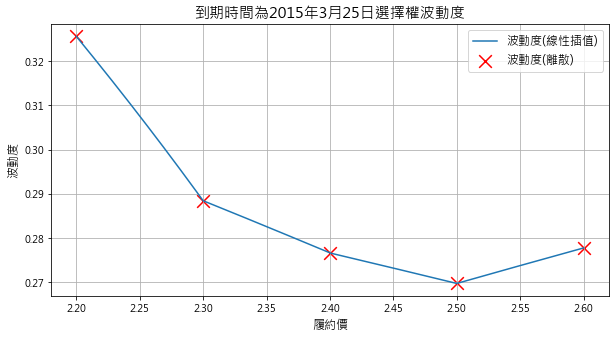

In [5]:
fig,ax=plt.subplots(1,figsize=(10,5))
ax.plot(K_Meshes,inter_vol_surface[:,0],label='波動度(線性插值)')
ax.scatter(strikes,black_vol_matrix[:,0],s=160,marker='x',color='r',label='波動度(離散)')
ax.set_title('到期時間為2015年3月25日選擇權波動度',fontsize=15)
ax.set_xlabel('履約價',fontsize=12)
ax.set_ylabel('波動度',fontsize=12)
ax.legend(fontsize=12)
ax.grid()

# 繪製選擇權波動度曲面圖

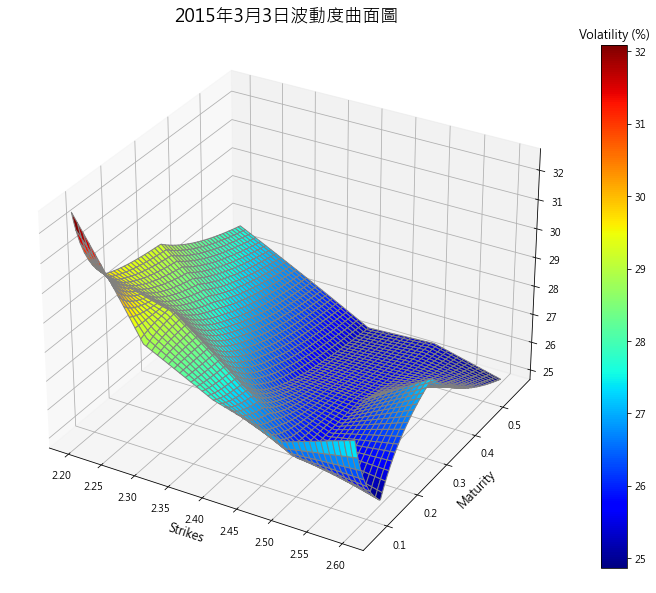

In [7]:
maturity_Mesher,strike_Mesher=np.meshgrid(T_Meshes,K_Meshes)


fig,ax=plt.subplots(1,figsize=(10,10),subplot_kw=dict(projection='3d'))
surface=ax.plot_surface(strike_Mesher,maturity_Mesher,inter_vol_surface*100,cmap=plt.cm.jet,edgecolor='gray')
cbar=plt.colorbar(surface,shrink=0.75)
cbar.ax.set_title('Volatility (%)')
ax.set_title('2015年3月3日波動度曲面圖',fontsize=18)
ax.set_xlabel('Strikes',fontsize=12)
ax.set_ylabel('Maturity',fontsize=12)
plt.tight_layout()
plt.show()